# Iris Dataset - Classification

## Problem definition
> Here we try to explore the iris dataset and to reach the best accuracy

## Data
https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

## Evaluation


### What will be covered
1. Import of common libraries
2. Data ingestion & cleaning
3. Data Analysis and visualization
4. Feature Selection
5. ML model selection
6. ML model tuning
7. Results visualizations
8. Model export
9. Python and html generation

#### Assumptions
* Data is provided with a single csv file with an header representing the columns'names

### Parameters

In [29]:
INPUT_DATA_FILE = 'data/example'
INSTALL_LIBRARIES = False
REMOVE_ROWS_WITH_INVALID_COLS = True #if False then a SimpleImputer will be used
MATPLOT_STYLE = 'seaborn-dark-palette'
TARGET_COLUMN = 'Species'
#if different from None it represents the number of wanted features in the feature selection step
NUM_FEATURES = 5
MODEL_EXP_PATH = 'bestClassifier.joblib'
OUTPUT_SCRIPT_NAME = 'modelPython.py'
OUTPUT_HTML_NAME = 'model_report.html'
MODEL_EXPORT = False
REPORT_GEN = False

columns_to_remove =[]

#not include the target in this list
column_to_visualize = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

column_names_and_types= {
         'Sepal Length': 'float64',
         'Sepal Width': 'float64',
         'Petal Length': 'float64',
         'Petal Width': 'float64',
         'Species': 'string'
        }

#this manage eventually data errors in the dataset using coerce
numeric_features = ['Sepal Length','Sepal Width','Petal Length','Petal Width']
datetime_features = []


from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#this will be used in step 5
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=30, max_features=0.6, n_jobs=-1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

### 1-Import of common libraries

In [30]:
if INSTALL_LIBRARIES:
    import sys
    !conda install --yes --prefix {sys.prefix} matplotlib
    !conda install --yes --prefix {sys.prefix} numpy
    !conda install --yes --prefix {sys.prefix} pandas
    !conda install --yes --prefix {sys.prefix} scikit-learn
    !conda install --yes --prefix {sys.prefix} ipython
    !conda install --yes --prefix {sys.prefix} seaborn

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from sklearn import metrics
from IPython.display import display
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import json
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
import heapq
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import datasets


%matplotlib inline



plt.style.use(MATPLOT_STYLE)
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (26, 20),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

### 2-Data ingestion & cleaning

In [31]:
data = datasets.load_iris()
raw_input_df = pd.DataFrame(data.data, columns=column_to_visualize)
raw_input_df[TARGET_COLUMN] = pd.Series(data.target)

In [32]:
#Here insert needed specific data cleaning and transformation steps
raw_input_df.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [33]:
raw_input_df = raw_input_df.drop(columns=columns_to_remove)

raw_input_df[numeric_features] = raw_input_df[numeric_features].apply(pd.to_numeric, errors='coerce')
raw_input_df= raw_input_df.astype(column_names_and_types, copy=False, errors='ignore')
raw_input_df[datetime_features] = raw_input_df[datetime_features].apply(pd.to_datetime, format='%Y/%m/%d %H:%M')

if REMOVE_ROWS_WITH_INVALID_COLS:
    raw_input_df = raw_input_df.dropna()
else:
    #TODO: simpleimpute numerical values
    pass

display(raw_input_df.head())
display(raw_input_df.describe())
display(raw_input_df.info())

,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


,Sepal Length,Sepal Width,Petal Length,Petal Width,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal Length  150 non-null    float64
 1   Sepal Width   150 non-null    float64
 2   Petal Length  150 non-null    float64
 3   Petal Width   150 non-null    float64
 4   Species       150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 6.4 KB


None

### 3-Data Analysis and visualization

<Figure size 1440x1080 with 0 Axes>

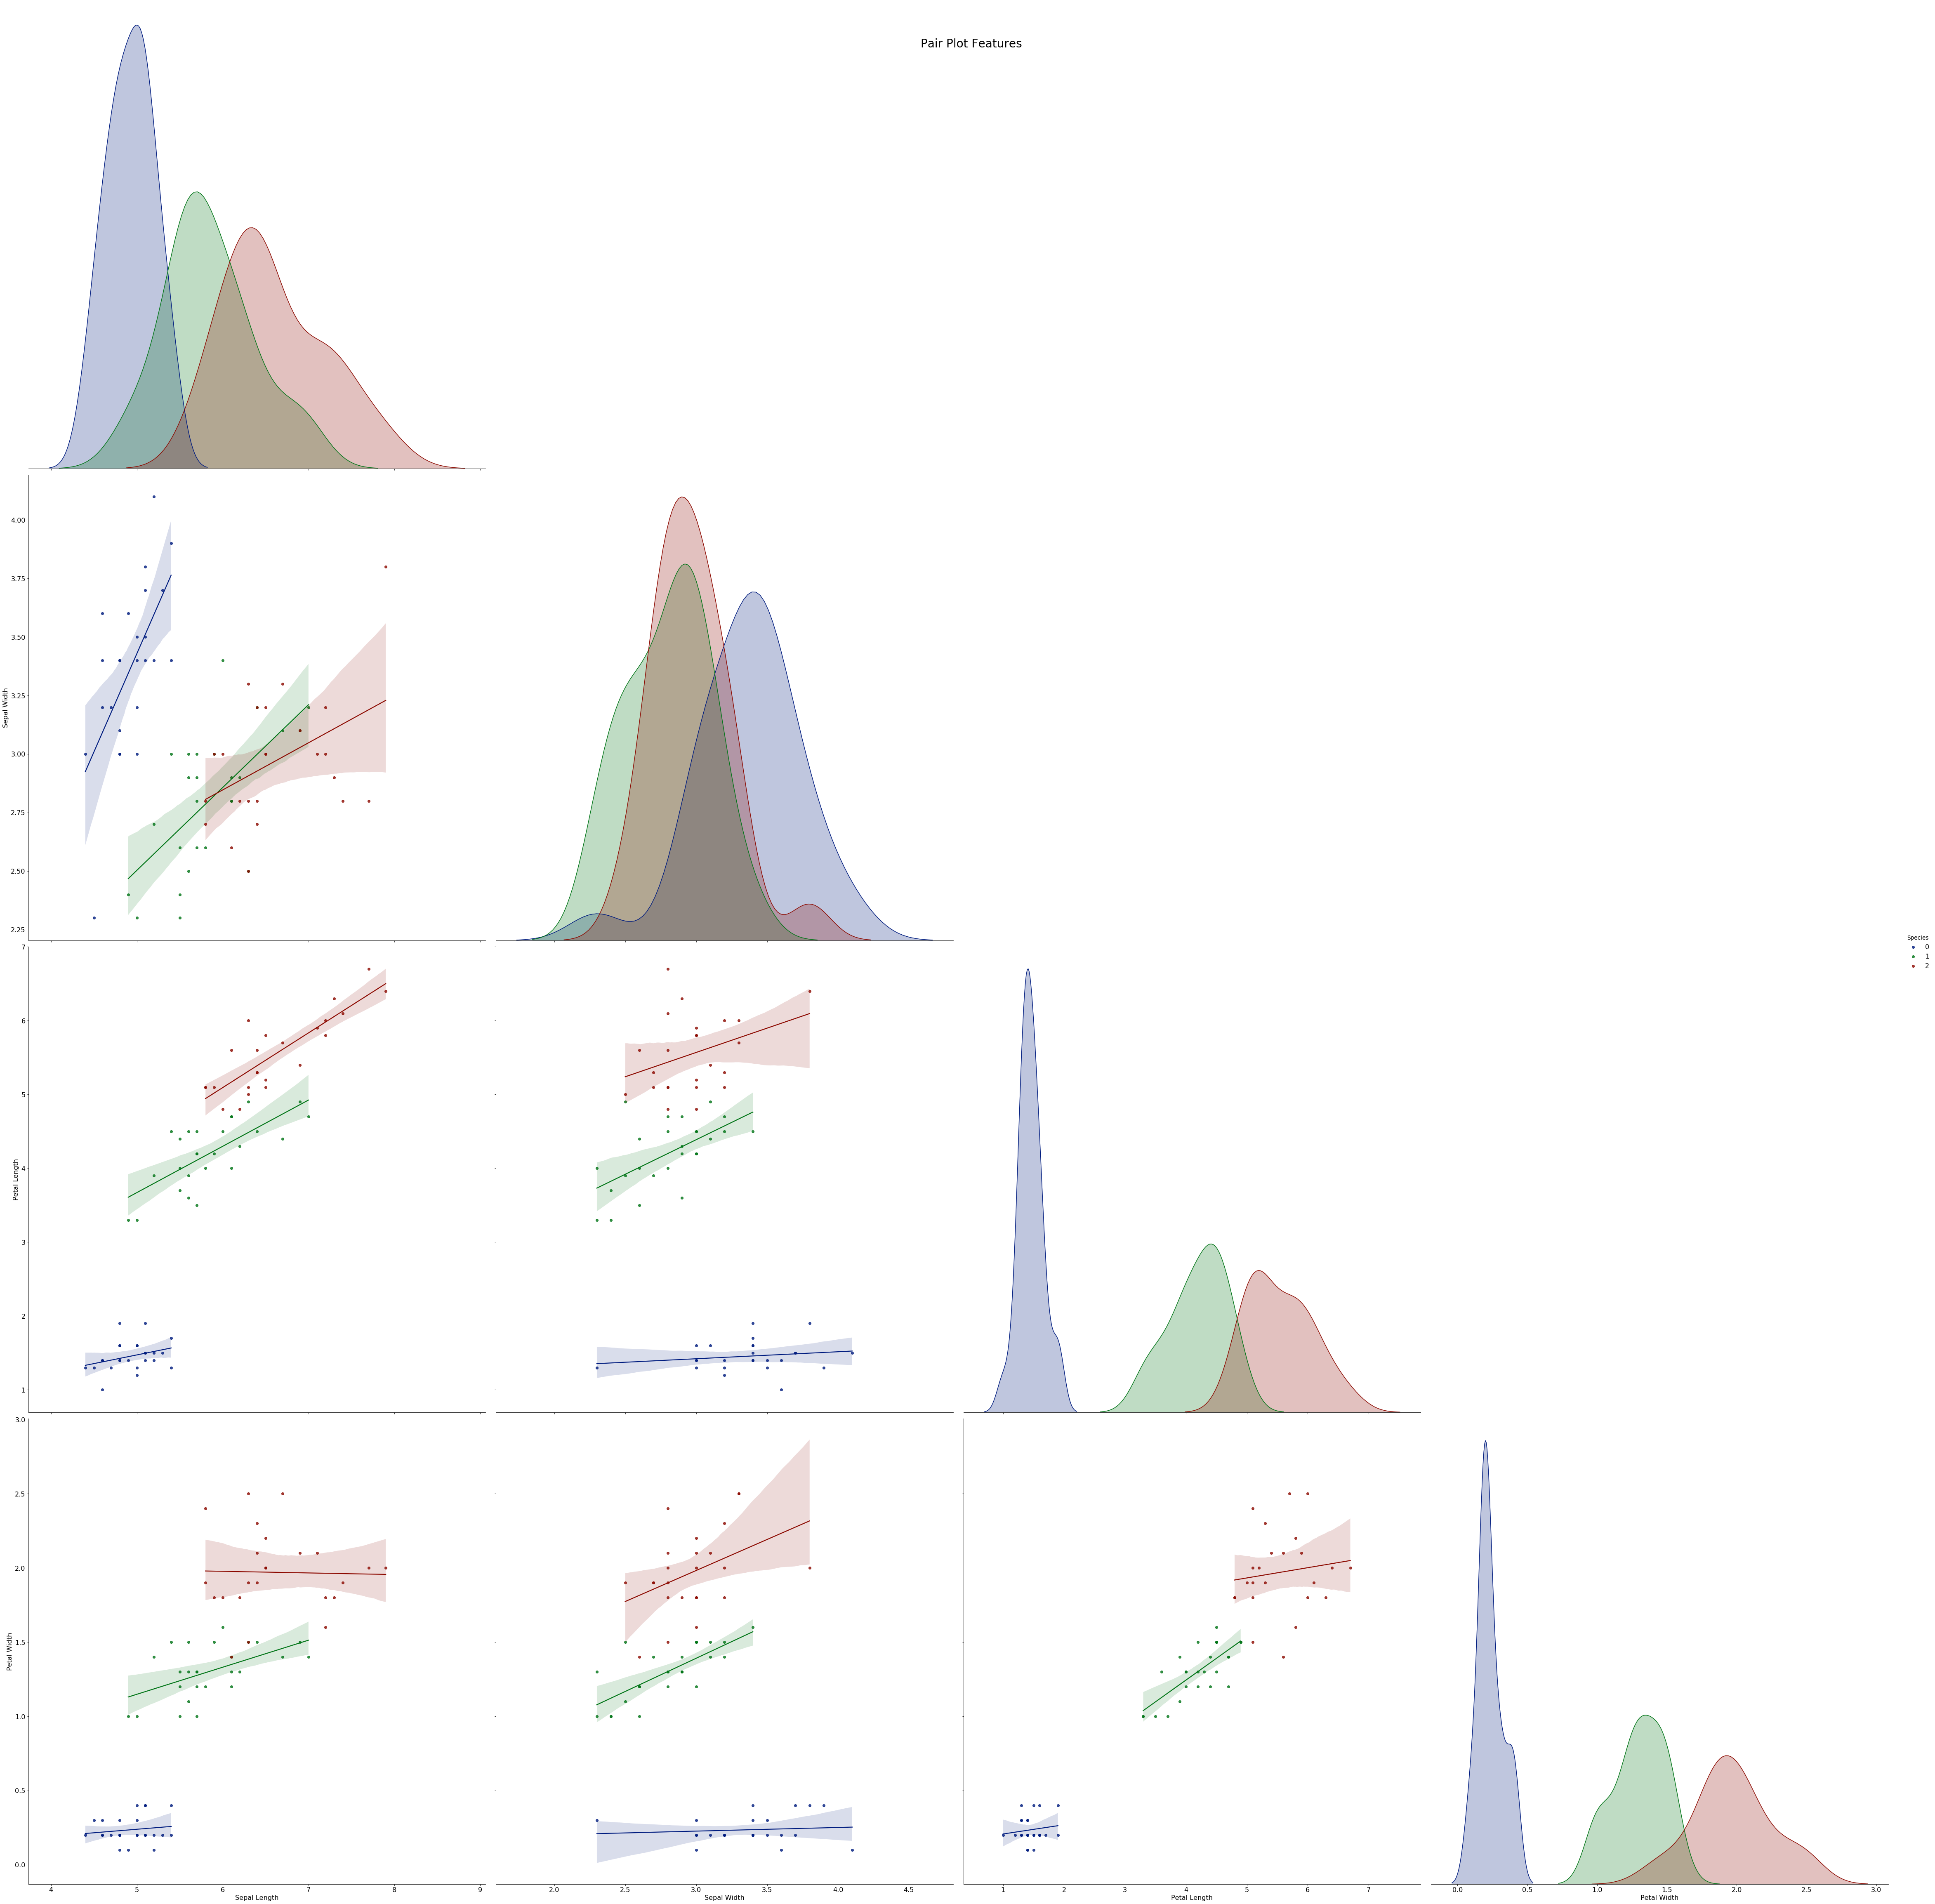

In [34]:
input_features = column_to_visualize
column_to_visualize.append(TARGET_COLUMN)

plt.figure(figsize=(20,15))
sns.pairplot(raw_input_df[column_to_visualize].sample(frac=0.5), kind="reg", hue=TARGET_COLUMN, corner=True, diag_kind="kde", height=16)
plt.suptitle('Pair Plot Features', size = 28);

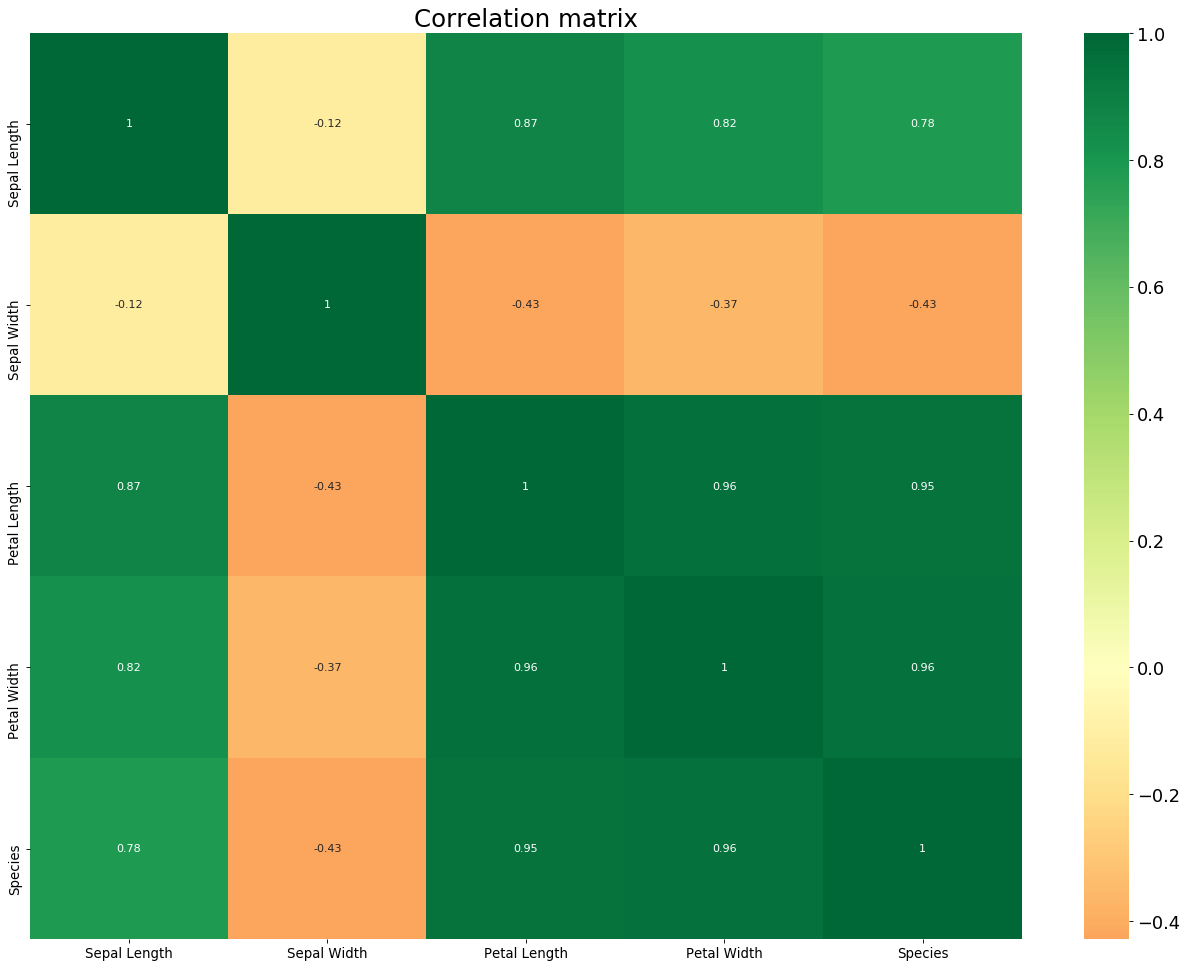

In [35]:
plt.figure(figsize=(20,15), dpi= 80)
sns.heatmap(raw_input_df[column_to_visualize].corr(), xticklabels=raw_input_df[column_to_visualize].corr().columns, yticklabels=raw_input_df[column_to_visualize].corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlation matrix', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

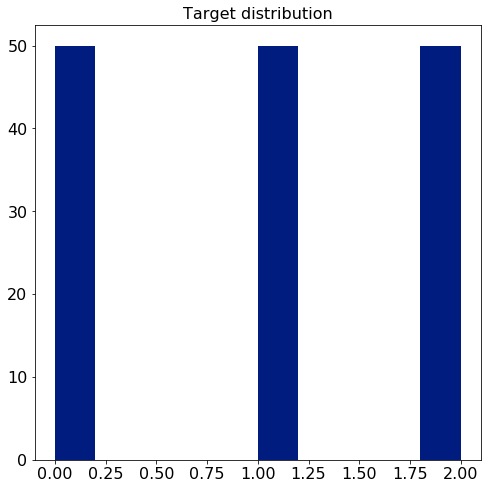

In [36]:
raw_input_df[TARGET_COLUMN].plot(kind='hist', subplots=True, figsize=(8, 8))
plt.title("Target distribution")
plt.ylabel("")
plt.show()

### 4-Feature Selection

In [37]:
new_features = input_features
input_features.remove(TARGET_COLUMN)
reduced = False
if NUM_FEATURES and NUM_FEATURES <= len(input_features):
    #feature_names = list(raw_input_df.columns.values)
    reduced = True
    # Create and fit selector
    select_k_best_classifier = SelectKBest(f_classif, k=NUM_FEATURES)
    fit_transofrmed_features = select_k_best_classifier.fit_transform(raw_input_df[input_features], raw_input_df[TARGET_COLUMN])
    
    mask = select_k_best_classifier.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, input_features):
        if bool:
            new_features.append(feature)
            
    print("Selected features are: %s" % new_features)
    input_df_reduced = pd.DataFrame(fit_transofrmed_features, columns=new_features)
    input_df_reduced[TARGET_COLUMN] = raw_input_df[TARGET_COLUMN].to_numpy()
    display(input_df_reduced.head())
    display(input_df_reduced.describe())
    display(input_df_reduced.info())
else:
    input_df_reduced = raw_input_df

### 5-ML model selection

In [38]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

# preprocess dataset, split into training and test part
X = input_df_reduced.loc[:, input_df_reduced.columns != TARGET_COLUMN]
y = input_df_reduced[TARGET_COLUMN]
X = StandardScaler().fit_transform(X) #ATTENTION: for each prediction we need to fit_transform first
X_train, X_validation, y_train, y_validation = \
    train_test_split(X, y, test_size=.3, random_state=42)
X_validation, X_test, y_validation, y_test = \
    train_test_split(X_validation, y_validation, test_size=.2, random_state=42)

#HERE MACROAVG_F1 IS USED, CHANGE IT IF YOU NEED
indexBestClassifier = 0
maxScore = 0
actualIndex = 0

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print("#"*10)
    print("Trying with classifier: {}".format(clf))
    clf.fit(X_train, y_train)
    score = clf.score(X_validation, y_validation)
    clf_report = classification_report(y_validation, clf.predict(X_validation), output_dict=True)
    print(json.dumps(clf_report,sort_keys=True, indent=4))
    score_to_use = float(clf_report["weighted avg"]["f1-score"])
    if score_to_use > maxScore:
        maxScore = score_to_use
        indexBestClassifier = actualIndex
    actualIndex +=1
    
print("The best classifier is: {} with score {}".format(classifiers[indexBestClassifier], maxScore))

##########
Trying with classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
{
    "0": {
        "f1-score": 1.0,
        "precision": 1.0,
        "recall": 1.0,
        "support": 16
    },
    "1": {
        "f1-score": 1.0,
        "precision": 1.0,
        "recall": 1.0,
        "support": 10
    },
    "2": {
        "f1-score": 1.0,
        "precision": 1.0,
        "recall": 1.0,
        "support": 10
    },
    "accuracy": 1.0,
    "macro avg": {
        "f1-score": 1.0,
        "precision": 1.0,
        "recall": 1.0,
        "support": 36
    },
    "weighted avg": {
        "f1-score": 1.0,
        "precision": 1.0,
        "recall": 1.0,
        "support": 36
    }
}
##########
Trying with classifier: SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='s

### 6-ML model tuning - to be modified manually

In [40]:
params = {
    'n_neighbors' : [3, 6, 8, 25, 66, 88],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

param_to_be_varied_in_validation_curve = 'n_neighbors'
param_range_valid_curve = [3, 6, 8, 25, 66, 88]

clf_best = RandomizedSearchCV(classifiers[indexBestClassifier], params, n_iter = 15, scoring='f1_weighted', random_state=42).fit(X,y)
#clf_best = GridSearchCV(classifiers[indexBestClassifier], params, scoring='f1_weighted').fit(X,y)
best_estimator = clf_best.best_estimator_
bestScore = clf_best.best_score_
results = pd.DataFrame(clf_best.cv_results_)
print("Results from hyperParams search: ")
print(json.dumps(results.to_dict(),indent=4))
print("Best classifier found: {} with score {}".format(best_estimator,bestScore))

Results from hyperParams search: 
{
    "mean_fit_time": {
        "0": 0.0009988784790039063,
        "1": 0.0008013248443603516,
        "2": 0.0012001991271972656,
        "3": 0.001000213623046875,
        "4": 0.0006002902984619141,
        "5": 0.001000690460205078,
        "6": 0.0014009475708007812,
        "7": 0.0009984970092773438,
        "8": 0.0010022163391113282,
        "9": 0.0010027885437011719,
        "10": 0.0010010242462158204,
        "11": 0.0010010242462158204,
        "12": 0.001199054718017578,
        "13": 0.0006003379821777344,
        "14": 0.0013993740081787109
    },
    "std_fit_time": {
        "0": 2.35347035965978e-06,
        "1": 0.00040066561077657165,
        "2": 0.0009784020735968588,
        "3": 1.1815559094776026e-06,
        "4": 0.0004901351231599204,
        "5": 0.0006312846831301467,
        "6": 0.0007994218971797964,
        "7": 1.8953902162887374e-06,
        "8": 1.6627879881060308e-06,
        "9": 5.223489356090222e-07,
        

### 7-Results visualizations

Score:  1.0
Misclassified len:  0
corrected_examples len:  9


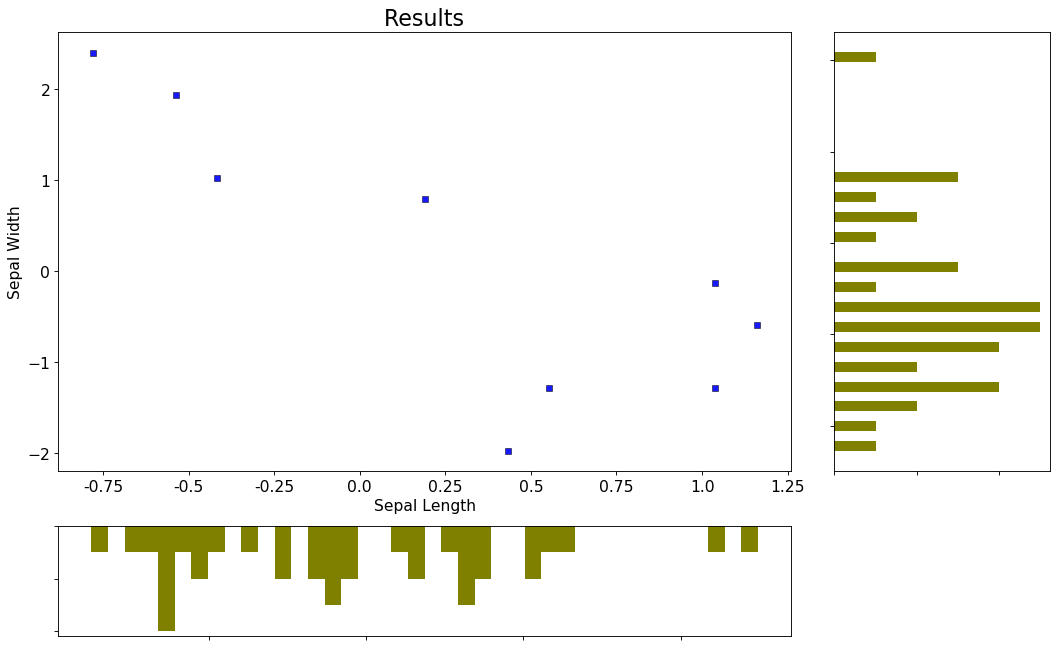

In [41]:
#Plot a scatter using the first 2 most important features and colour in red the yellow 
y_pred = best_estimator.predict(X_test)
print("Score: ",best_estimator.score(X_test,y_test))
misclassified_examples = X_test[y_test != y_pred]
print("Misclassified len: ",len(misclassified_examples))
misclassified_examples = pd.DataFrame(misclassified_examples,columns=new_features)
corrected_examples = X_test[y_test == y_pred]
print("corrected_examples len: ",len(corrected_examples))
corrected_examples = pd.DataFrame(corrected_examples,columns=new_features)
if reduced:
    list_scores = list(select_k_best_classifier.scores_)
    print("list_scores: ",list_scores)
    two_best_scores = heapq.nlargest(2, list_scores)
    print("two_best_scores: ",two_best_scores)
    best_feature_one = input_features[list_scores.index(two_best_scores[0])]
    print("best_feature_one: ",best_feature_one)
    best_feature_two = input_features[list_scores.index(two_best_scores[1])]
    print("best_feature_two: ",best_feature_two)
else:
    best_feature_one = input_features[0]
    best_feature_two = input_features[1]

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])


# Scatterplot on main ax
ax_main.scatter(corrected_examples[best_feature_one], corrected_examples[best_feature_two], label='correct',marker="s", c='blue', alpha=.9, cmap="tab10", edgecolors='black', linewidths=.5)
ax_main.scatter(misclassified_examples[best_feature_one], misclassified_examples[best_feature_two], label='errors',marker="s", c='yellow', alpha=.9, cmap="tab10", edgecolors='red', linewidths=.5)

X_validation_df = pd.DataFrame(X_validation,columns=new_features)

# histogram on the right
ax_bottom.hist(X_validation_df[best_feature_one], 40, histtype='stepfilled', orientation='vertical', color='olive')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(X_validation_df[best_feature_two], 40, histtype='stepfilled', orientation='horizontal', color='olive')

# Decorations
ax_main.set(title='Results', xlabel=best_feature_one, ylabel=best_feature_two)
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

xlabels = ax_main.get_xticks().tolist()
ax_main.set_xticklabels(xlabels)
plt.show()

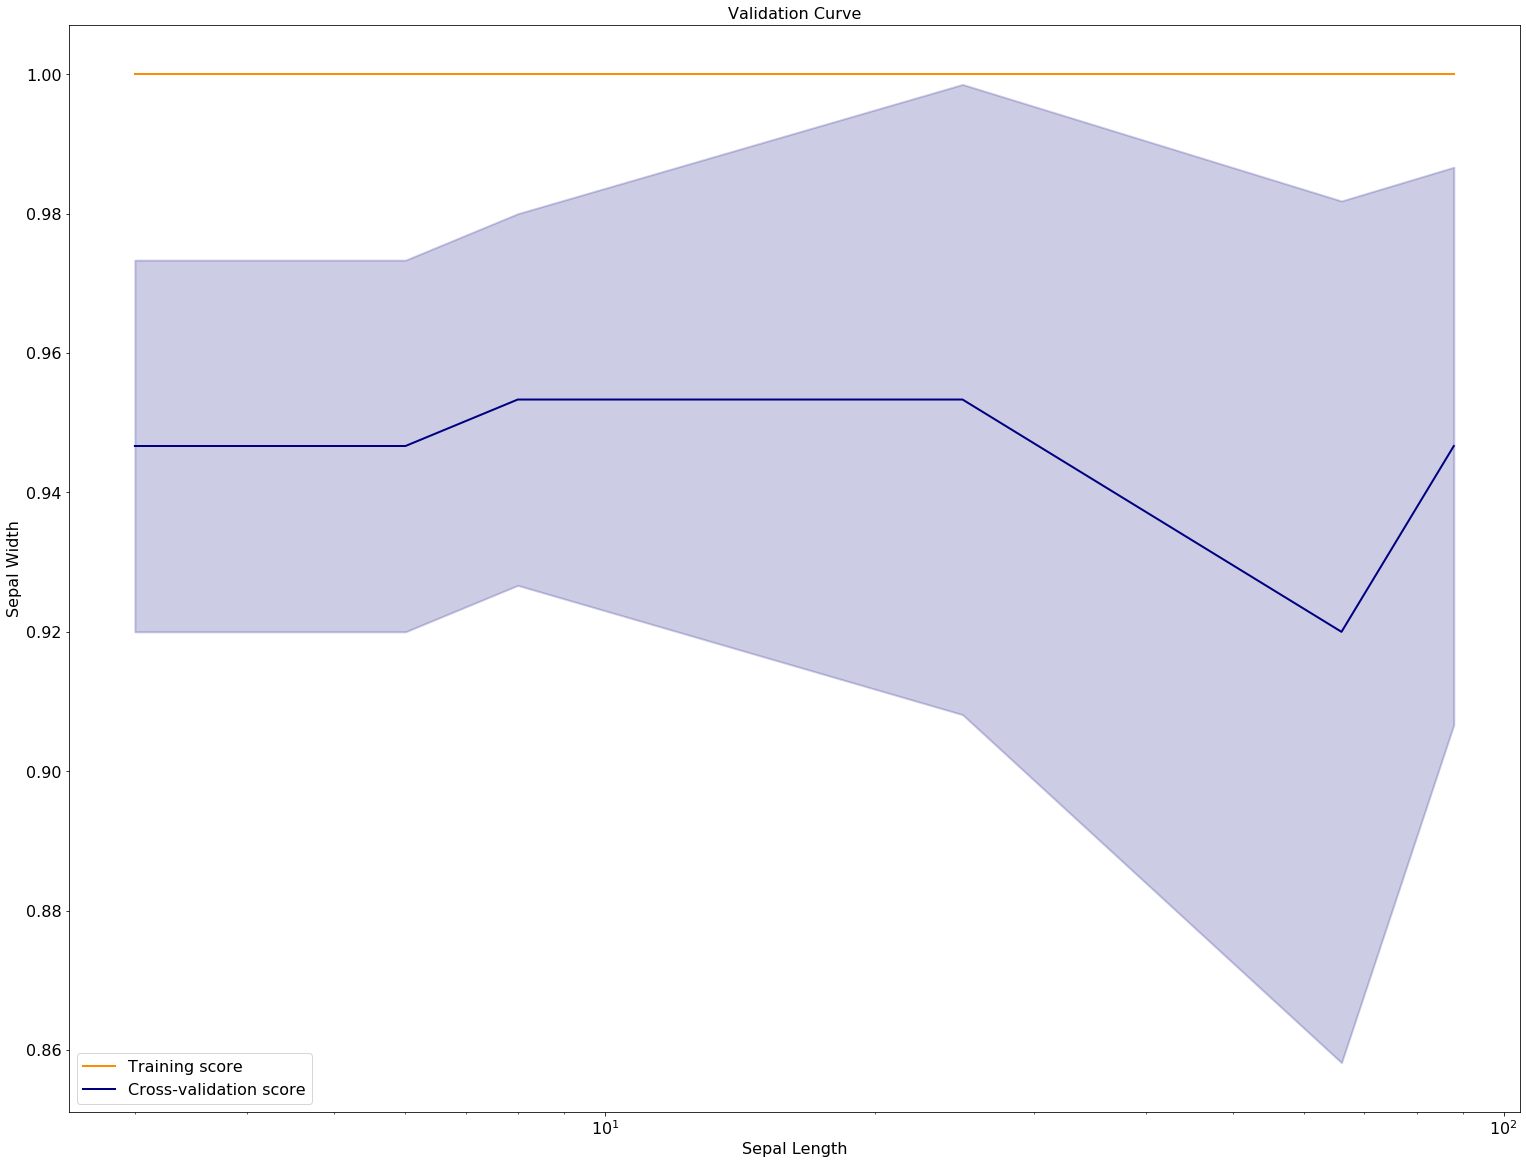

In [42]:
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X_shuffled, y_shuffled = X[indices], y[indices]

train_scores, valid_scores = validation_curve(best_estimator, X_shuffled, y_shuffled,
                                              param_to_be_varied_in_validation_curve,
                                              param_range_valid_curve,
                                              cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel(best_feature_one)
plt.ylabel(best_feature_two)
lw = 2
plt.semilogx(param_range_valid_curve, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range_valid_curve, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range_valid_curve, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range_valid_curve, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

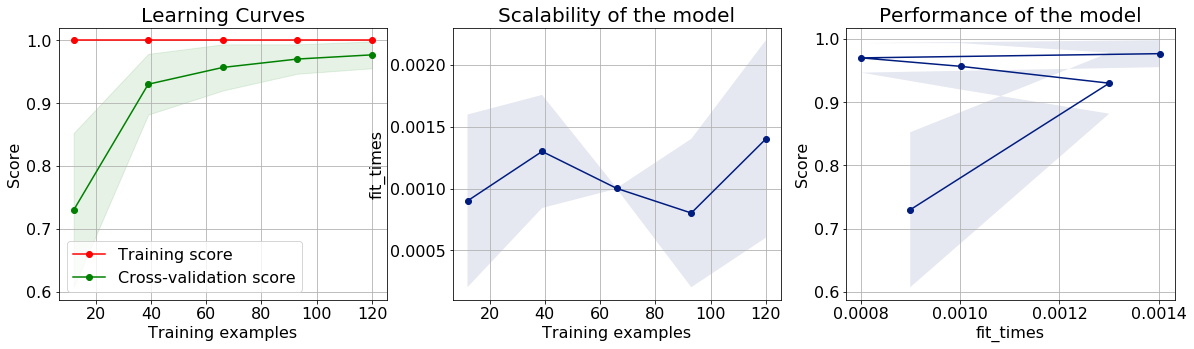

In [43]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    axes[0].title.set_fontsize(20)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    axes[1].title.set_fontsize(20)

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    axes[2].title.set_fontsize(20)

    return plt


title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = best_estimator
plot_learning_curve(estimator, title, X, y,cv=cv, n_jobs=-1)

plt.show()

### 8-Model export

In [ ]:
if MODEL_EXPORT:
    from joblib import dump, load
    dump(best_estimator, MODEL_EXP_PATH)

### 9-Python and html generation

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

In [ ]:
if REPORT_GEN:
    import nbformat
    from nbconvert import PythonExporter
    import os
    import codecs
    from IPython.display import Javascript
    import time
    from nbconvert import HTMLExporter


    def convertNotebook(notebookPath, modulePath):

      with open(notebookPath) as fh:
        nb = nbformat.reads(fh.read(), nbformat.NO_CONVERT)

      exporter = PythonExporter()
      source, meta = exporter.from_notebook_node(nb)
      with open(modulePath, 'w+') as fh:
        fh.writelines(source)


    def save_notebook():
        display(
            Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript']
        )

    def output_HTML(read_file, output_file):
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    nb_full_path = os.path.join(os.getcwd(), theNotebook)
    convertNotebook(nb_full_path+".ipynb", OUTPUT_SCRIPT_NAME)

    save_notebook()
    time.sleep(3)
    current_file = theNotebook+".ipynb"
    output_HTML(current_file, OUTPUT_HTML_NAME)